In [315]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn

import matplotlib.pyplot as plt

from nn_functions import init_network_params, pack_params, layer_sizes, unpack_params
from nn_functions import update_sgd, compute_hessian, update_adam
from nn_functions import (
    get_batches,
    loss,
    batched_predict,
    batched_predict_with_activations,
)

In [316]:
# Load data
field = jnp.load("field.npy")
field = field - field.mean()
field = field / field.std()
field = jnp.array(field, dtype=jnp.float32)
nx, ny = field.shape
xx = jnp.linspace(-1, 1, nx)
yy = jnp.linspace(-1, 1, ny)
xx, yy = jnp.meshgrid(xx, yy, indexing="ij")
xx = jnp.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
ff = field.reshape(-1, 1)

In [318]:
from jax import random, grad
from jax.tree_util import tree_map
import jax.numpy as jnp


def train_model(
    num_epochs=400,
    rng_key=random.key(0),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
):
    # Inicializar red
    params = init_network_params(layer_sizes, rng_key)
    params = pack_params(params)

    # Inicializar Adam (o SGD si se adapta la interfaz)
    aux_m = tree_map(jnp.zeros_like, params)
    aux_v = tree_map(jnp.zeros_like, params)
    aux_t = 0
    aux = (aux_m, aux_v, aux_t)

    # Logging
    log_train = []
    log_grads = []
    log_activations = []
    log_hessian = []
    log_params = []

    # Early stopping
    best_loss = float("inf")
    wait = 0

    for epoch in range(num_epochs):
        idxs = random.permutation(rng_key, xx.shape[0])
        for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
            params, aux, grads = update(params, xi, yi, step_size, aux)

        train_loss = loss(params, xx, ff)
        log_train.append(train_loss.item())

        # Early stopping
        if train_loss < best_loss - tol_loss:
            best_loss = train_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Corte temprano por paciencia en epoch {epoch}")
                break

        # Logging cada 20 epochs
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            grads = grad(loss)(params, xx, ff)
            log_grads.append(grads)
            outputs, activations = batched_predict_with_activations(params, xx)
            log_activations.append(activations)
            xi, yi = next(get_batches(xx, ff, bs=batch_size))  # para el Hessiano
            log_hessian.append(compute_hessian(params, xi, yi))
            log_params.append(params)
            # log_hessian.append(compute_hessian(params, xx, ff))
            print(f"Epoch {epoch}, Loss: {train_loss}")

    return {
        "params": params,
        "log_train": log_train,
        "log_params": log_params,
        "log_grads": log_grads,
        "log_activations": log_activations,
        "log_hessian": log_hessian,
        "final_epoch": epoch,
        "final_loss": train_loss.item(),
    }

# Con scheduler con performance

In [ ]:
def train_model(
    num_epochs=400,
    rng_key=random.key(0),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
    use_scheduler=True,
    lr_decay=0.5,
    lr_patience=5,
    min_step_size=1e-6,
):
    # Inicializar red
    params = init_network_params(layer_sizes, rng_key)
    params = pack_params(params)

    # Inicializar Adam (o SGD)
    aux_m = tree_map(jnp.zeros_like, params)
    aux_v = tree_map(jnp.zeros_like, params)
    aux_t = 0
    aux = (aux_m, aux_v, aux_t)

    # Logging
    log_train = []
    log_grads = []
    log_activations = []
    log_hessian = []

    # Early stopping y scheduler
    best_loss = float("inf")
    wait = 0
    lr_wait = 0  # contador separado para el scheduler

    for epoch in range(num_epochs):
        idxs = random.permutation(rng_key, xx.shape[0])
        for xi, yi in get_batches(xx[idxs], ff[idxs], bs=batch_size):
            params, aux, grads = update(params, xi, yi, step_size, aux)

        train_loss = loss(params, xx, ff)
        log_train.append(train_loss.item())

        # Early stopping
        if train_loss < best_loss - tol_loss:
            best_loss = train_loss
            wait = 0
            lr_wait = 0
        else:
            wait += 1
            lr_wait += 1
            if wait >= patience:
                print(f"Corte temprano por paciencia en epoch {epoch}")
                break
            # Scheduler
            if use_scheduler and lr_wait >= lr_patience:
                old_step_size = step_size
                step_size = max(min_step_size, step_size * lr_decay)
                lr_wait = 0
                print(
                    f"Reduciendo step_size: {old_step_size:.5f} → {step_size:.5f} (epoch {epoch})"
                )

        # Logging
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            grads = grad(loss)(params, xx, ff)
            log_grads.append(grads)
            outputs, activations = batched_predict_with_activations(params, xx)
            log_activations.append(activations)
            # xi, yi = next(get_batches(xx, ff, bs=batch_size))
            log_hessian.append(compute_hessian(params, xx, ff))
            print(f"Epoch {epoch}, Loss: {train_loss:.5f}")

    return {
        "params": params,
        "log_train": log_train,
        "log_grads": log_grads,
        "log_activations": log_activations,
        "log_hessian": log_hessian,
        "final_epoch": epoch,
        "final_loss": train_loss.item(),
        "final_step_size": step_size,
    }

In [154]:
results = train_model(
    num_epochs=400,
    rng_key=random.key(65),
    batch_size=64,
    step_size=0.01,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
    use_scheduler=True,
    lr_decay=0.5,
    lr_patience=5,
    min_step_size=1e-6,
)

Epoch 0, Loss: 0.06535
Epoch 10, Loss: 0.03577
Epoch 20, Loss: 0.02689
Epoch 30, Loss: 0.02485
Reduciendo step_size: 0.01000 → 0.00500 (epoch 36)
Epoch 40, Loss: 0.01771
Epoch 50, Loss: 0.01676
Epoch 60, Loss: 0.01621
Reduciendo step_size: 0.00500 → 0.00250 (epoch 66)
Epoch 70, Loss: 0.01536
Reduciendo step_size: 0.00250 → 0.00125 (epoch 72)
Epoch 80, Loss: 0.01408
Epoch 90, Loss: 0.01373
Epoch 100, Loss: 0.01338
Epoch 110, Loss: 0.01303
Epoch 120, Loss: 0.01277
Epoch 130, Loss: 0.01258
Epoch 140, Loss: 0.01240
Epoch 150, Loss: 0.01223
Epoch 160, Loss: 0.01208
Epoch 170, Loss: 0.01192
Epoch 180, Loss: 0.01178
Epoch 190, Loss: 0.01164
Epoch 200, Loss: 0.01150
Epoch 210, Loss: 0.01137
Epoch 220, Loss: 0.01125
Epoch 230, Loss: 0.01114
Epoch 240, Loss: 0.01104
Epoch 250, Loss: 0.01092
Epoch 260, Loss: 0.01083
Epoch 270, Loss: 0.01074
Epoch 280, Loss: 0.01066
Epoch 290, Loss: 0.01057
Epoch 300, Loss: 0.01049
Epoch 310, Loss: 0.01040
Epoch 320, Loss: 0.01029
Epoch 330, Loss: 0.01018
Epoch 34

In [319]:
"""
A mayor batch_size, suele hacer falta un learning_rate más alto.
A menor batch_size, conviene un learning_rate más bajo.
"""

results = train_model(
    num_epochs=400,
    rng_key=random.key(65),
    batch_size=64,
    step_size=0.005,
    update=update_adam,
    patience=10,
    tol_loss=1e-5,
)

Epoch 0, Loss: 0.06840823590755463
Epoch 10, Loss: 0.032237760722637177
Epoch 20, Loss: 0.030960405245423317
Epoch 30, Loss: 0.02672305516898632
Epoch 40, Loss: 0.023798758164048195
Epoch 50, Loss: 0.021582603454589844
Epoch 60, Loss: 0.0194491446018219
Epoch 70, Loss: 0.01773824356496334
Epoch 80, Loss: 0.017257504165172577
Epoch 90, Loss: 0.016838788986206055
Epoch 100, Loss: 0.01633470691740513
Epoch 110, Loss: 0.015790332108736038
Epoch 120, Loss: 0.01556898932904005
Epoch 130, Loss: 0.015439819544553757
Epoch 140, Loss: 0.014886328019201756
Epoch 150, Loss: 0.014395516365766525
Epoch 160, Loss: 0.013987423852086067
Epoch 170, Loss: 0.013776241801679134
Epoch 180, Loss: 0.013240167871117592
Epoch 190, Loss: 0.012788726948201656
Epoch 200, Loss: 0.012329989112913609
Epoch 210, Loss: 0.012106685899198055
Epoch 220, Loss: 0.011921421624720097
Epoch 230, Loss: 0.011632870882749557
Epoch 240, Loss: 0.011379730887711048
Epoch 250, Loss: 0.011048371903598309
Epoch 260, Loss: 0.01091941911

In [162]:
results_con_scheduling = results

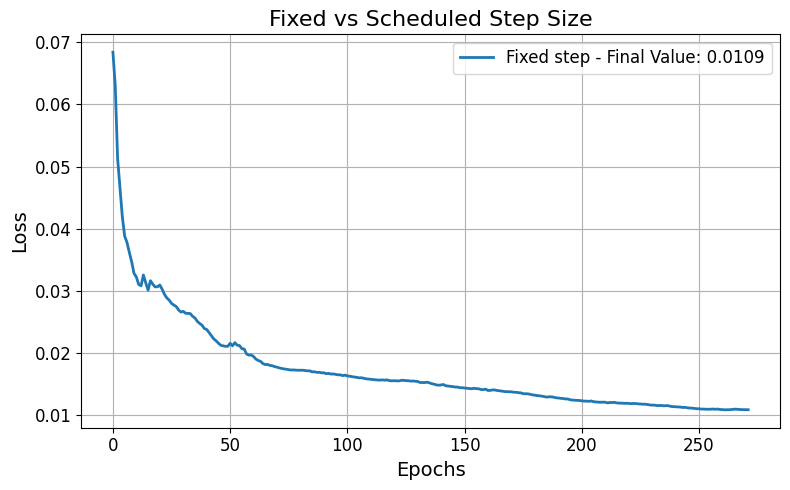

In [281]:
plt.figure(figsize=(8, 5))  # Tamaño del gráfico

# plt.plot(results_con_scheduling["log_train"], label=f'Scheduling - Final Value: {results_con_scheduling["log_train"][-1]:.4f}', linewidth=2)
plt.plot(
    results["log_train"],
    label=f'Fixed step - Final Value: {results["log_train"][-1]:.4f}',
    linewidth=2,
)

plt.title(f"Fixed vs Scheduled Step Size", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Loss", fontsize=14)

plt.grid(True)
plt.legend(fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

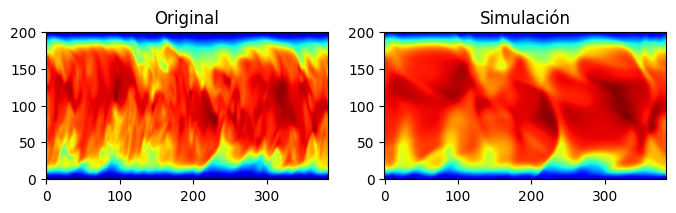

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].imshow(ff.reshape((nx, ny)).T, origin="lower", cmap="jet")
axes[0].set_title(f"Original")
result = batched_predict(results_con_scheduling["params"], xx)
axes[1].imshow(result.reshape((nx, ny)).T, origin="lower", cmap="jet")
axes[1].set_title(f"Simulación")

plt.show()

In [ ]:
import seaborn as sns


def graficar_gradientes(results):
    # Inicializamos estructuras para acumular gradientes
    num_layers = len(layer_sizes) - 1
    grad_weights_by_layer = [[] for _ in range(num_layers)]
    grad_biases_by_layer = [[] for _ in range(num_layers)]
    log_grads = results
    # Recolectamos gradientes por capa y tipo
    for grads in log_grads:
        layer_grads = unpack_params(grads)  # Lista de (w, b) por capa
        for i, (w, b) in enumerate(layer_grads):
            grad_weights_by_layer[i].append(w.flatten())
            grad_biases_by_layer[i].append(b.flatten())
    return grad_weights_by_layer, grad_biases_by_layer


def plot_distributions(data_by_layer, param_type):
    for i, layer_data in enumerate(
        data_by_layer[:-1]
    ):  # layer_data: lista de arrays (uno por época)
        plt.figure(figsize=(8, 5))
        for j, values in enumerate(layer_data):
            if j == 0 or j == 1 or j == int(5) or j == len(layer_data) - 1:
                sns.kdeplot(values, label=f"{10*j}", linewidth=2)
        plt.title(f"Distribución de ∇Loss con respecto a {param_type} - Capa {i+1}")
        # plt.xlabel("Valor")
        plt.ylabel("Densidad estimada")
        plt.grid(True)
        plt.legend()
        plt.legend(title="# Epoch:")
        plt.tight_layout()
        plt.show()

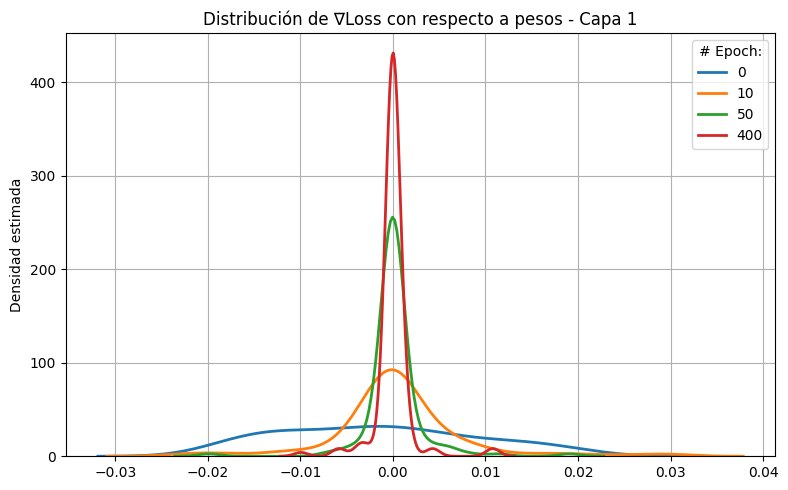

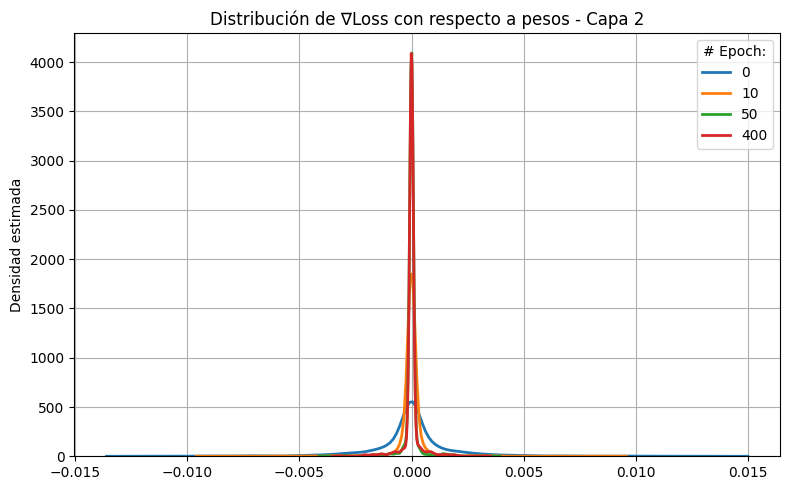

In [157]:
grad_weights_by_layer, grad_biases_by_layer = graficar_gradientes(results["log_grads"])
plot_distributions(grad_weights_by_layer, "pesos")

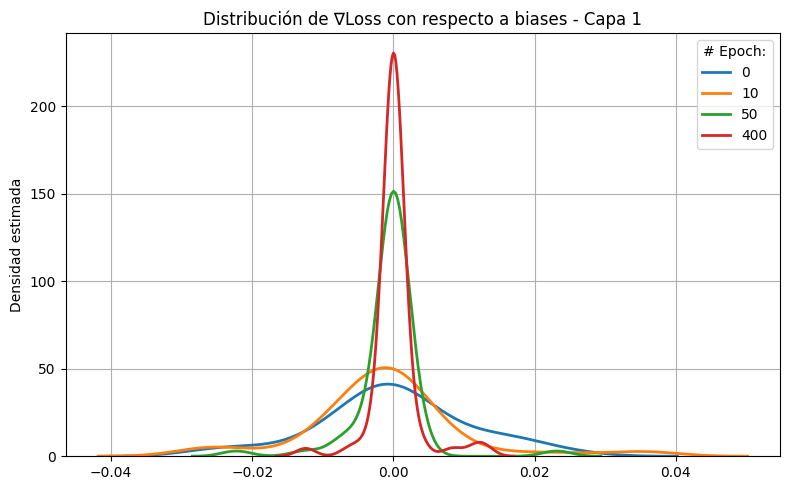

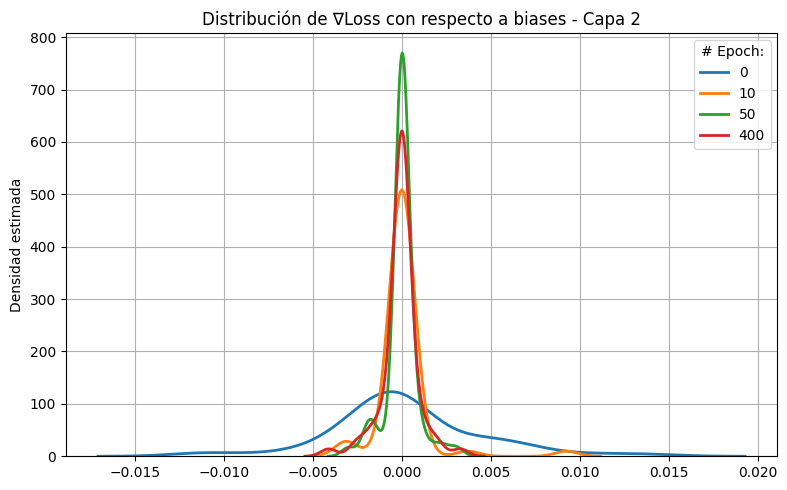

In [158]:
plot_distributions(grad_biases_by_layer, "biases")

# Activaciones

In [ ]:
import numpy as np


def plot_activations_distributions(log_activations, layer_index, epoch_interval=10):
    plt.figure(figsize=(8, 5))

    num_epochs = len(log_activations)
    colors = plt.cm.viridis(np.linspace(0, 1, num_epochs))

    for i, activs in enumerate(log_activations):
        if i == 0 or i == int(5) or i == len(log_activations) - 1:
            # epoch = i * epoch_interval  # ya que guardás cada 10 epochs
            data = np.ravel(
                np.array(activs[layer_index])
            )  # activaciones de la capa, a 1D
            # plt.hist(data, bins=50, alpha=0.5, label=f'Epoch {epoch}', color=colors[i], density=True)
            sns.kdeplot(data, label=f"{10*i}", linewidth=2)
            # print(len(data))
    plt.title(f"Activaciones - Capa {layer_index +1}")
    # plt.xlabel("Valor de activación")
    plt.ylabel("Densidad estimada")
    plt.grid(True)
    plt.legend(title="# Epoch:")
    plt.tight_layout()
    plt.show()

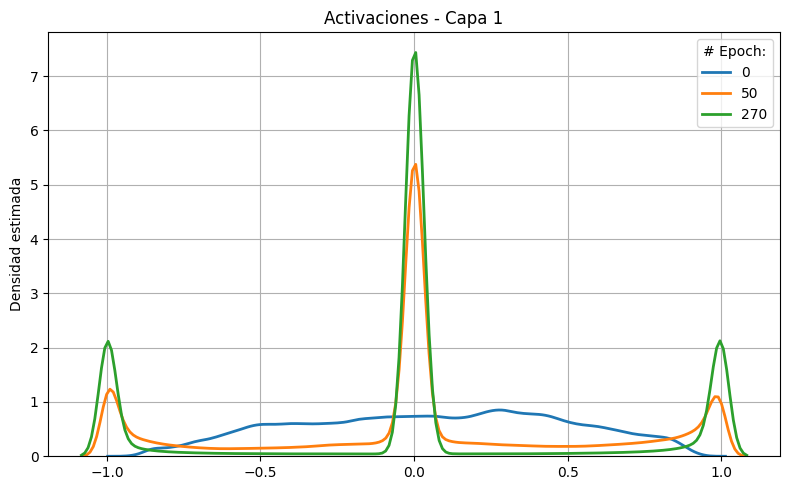

In [209]:
plot_activations_distributions(results["log_activations"], layer_index=0)

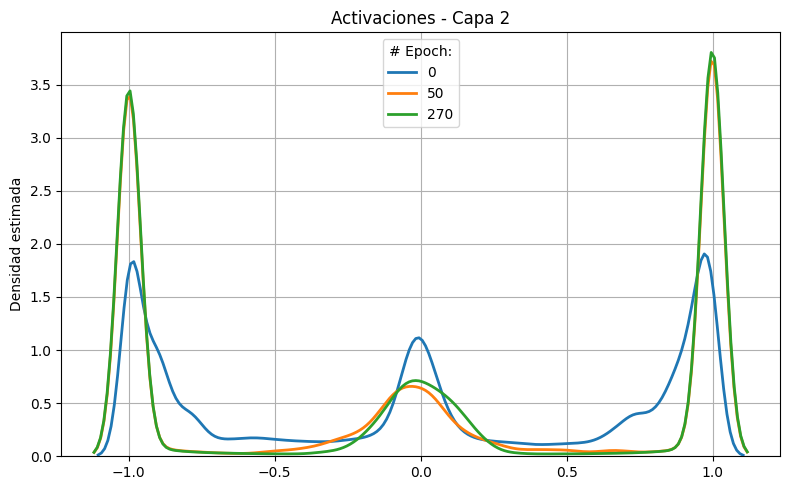

In [210]:
plot_activations_distributions(results["log_activations"], layer_index=1)

# Hessiano

In [ ]:
log_hessian = results["log_hessian"]
ncols = 2  # columnas por fila
nrows = (len(log_hessian) + ncols - 1) // ncols  # filas necesarias

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = axes.flatten()  # aplanamos para indexar fácil

for i, hessian in enumerate(log_hessian):
    eigvals, _ = jnp.linalg.eigh(hessian)
    eigvals = jnp.array(eigvals)
    abs_eig = jnp.abs(eigvals)

    # Para evitar división por cero en autovalores muy chicos
    lambda_max = jnp.max(abs_eig)
    lambda_min = jnp.clip(jnp.min(abs_eig), a_min=1e-10)  # evitar división por 0

    bins = jnp.logspace(jnp.log10(0.000001), jnp.log10(100), num=40)

    #  axes[i].hist(eigvals, bins=40, color="steelblue", edgecolor="black")
    axes[i].hist(eigvals, bins=bins, color="steelblue", edgecolor="black")
    axes[i].set_title(
        f"Epoch {i*10}, Nro. condicion{lambda_max / lambda_min}"
    )  # o el número real si lo tenés
    axes[i].set_xlabel("Autovalores")
    axes[i].set_ylabel("Frecuencia")
    axes[i].set_xscale("log")  # ← Escala log en eje Y (frecuencia)


# Apagar subplots vacíos si hay
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [230]:
log_hessian = results["log_hessian"]
max_autoval = []
for i, hessian in enumerate(log_hessian):
    eigvals, _ = jnp.linalg.eigh(hessian)
    eigvals = jnp.array(eigvals)
    abs_eig = jnp.abs(eigvals)
    # Para evitar división por cero en autovalores muy chicos
    lambda_max = jnp.max(abs_eig)
    max_autoval.append(lambda_max)

127.01557
113.341156
109.36798
108.454506
108.86551
107.98063
107.652885
109.091675
114.51674
109.83636
106.42419
103.014626
101.02658
99.18125
98.73696
97.63963
97.155716
96.602295
96.12666
95.93699
95.42531
95.6283
95.56132
95.993
95.866745
96.55881
96.4266
95.86272


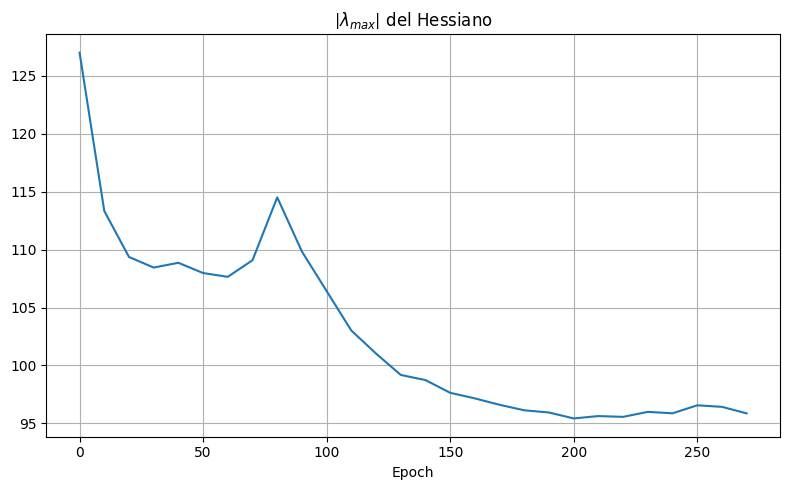

In [242]:
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0, len(max_autoval), 1) * 10, max_autoval)
plt.title(r"$ \left | \lambda _{max}\right |$ del Hessiano")
# plt.xlabel("Valor de activación")
plt.xlabel("Epoch")
plt.grid(True)
# plt.legend(title="# Epoch:")
plt.tight_layout()
plt.show()

In [306]:
epsilon = 1e-5  # tolerancia para considerar "igual a cero"
mask = jnp.abs(xx[:, 1]) < epsilon

xx_filt = xx[mask]
ff_filt = ff[mask]

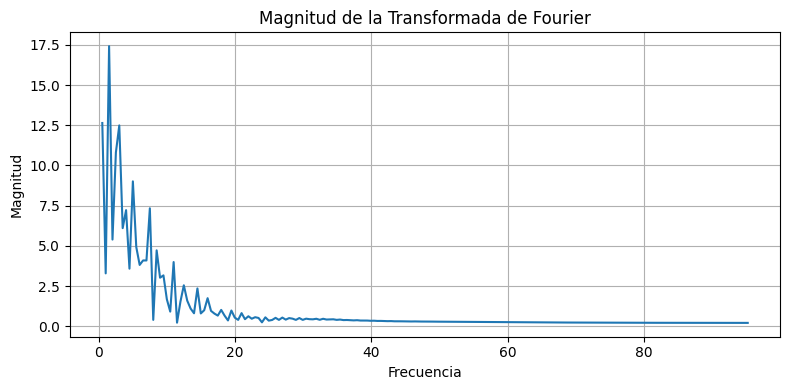

In [313]:
result = batched_predict(results["params"], xx_filt)
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Aplanar y ordenar por x (por si no están ordenados)


pred_vals = result.flatten()  # resultado de la red neuronal

# Calcular la FFT
fft_vals = jnp.fft.fft(pred_vals)
freqs = jnp.fft.fftfreq(len(pred_vals), d=(xx_filt[1, 0] - xx_filt[0, 0] ))

# Magnitud de la FFT
fft_magnitude = jnp.abs(fft_vals)

# Graficar (sólo frecuencias positivas)
mask = freqs > 0
plt.figure(figsize=(8, 4))
plt.plot(freqs[mask], fft_magnitude[mask])
plt.title("Magnitud de la Transformada de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

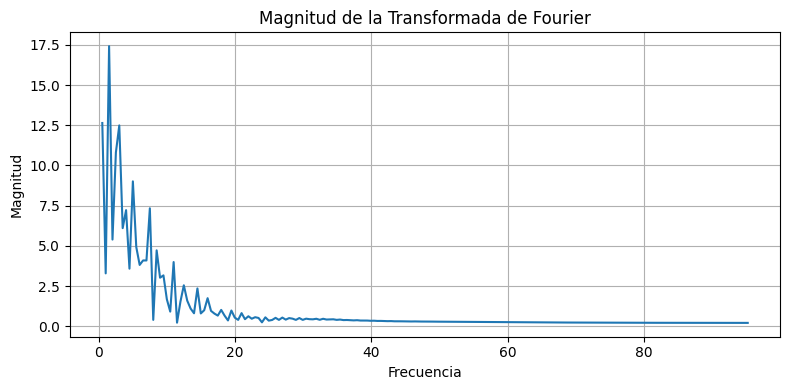

In [312]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Aplanar y ordenar por x (por si no están ordenados)
result= batched_predict(results["params"], xx_filt)
sorted_idx = jnp.argsort(xx_filt[:, 0])
x_vals = xx_filt[:, 0][sorted_idx]
pred_vals = result.flatten()[sorted_idx]  # resultado de la red neuronal


# Calcular la FFT
fft_vals = jnp.fft.fft(pred_vals)
freqs = jnp.fft.fftfreq(len(pred_vals), d=(x_vals[1] - x_vals[0]))

# Magnitud de la FFT
fft_magnitude = jnp.abs(fft_vals)

# Graficar (sólo frecuencias positivas)
mask = freqs > 0
plt.figure(figsize=(8, 4))
plt.plot(freqs[mask], fft_magnitude[mask])
plt.title("Magnitud de la Transformada de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.grid(True)
plt.tight_layout()
plt.show()

In [327]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

def plot_ffts_during_training(log_params, xx_filt, x_coords, model_fn):
    """
    log_params: lista de params guardados durante el entrenamiento (cada 10 epochs)
    xx_filt: puntos de entrada (e.g. mitad del campo en eje y)
    x_coords: coordenadas x correspondientes a xx_filt[:, 0]
    model_fn: función que toma (params, x) y devuelve la predicción
    """
    indices = [0, len(log_params) // 10, len(log_params) - 1]  # inicio, medio, final
    labels = ["Inicio", "Mitad", "Final"]

    plt.figure(figsize=(10, 5))

    for idx, label in zip(indices, labels):
        params = log_params[idx]
        pred = model_fn(params, xx_filt).flatten()

        # FFT
        fft_vals = jnp.fft.fft(pred)
        freqs = jnp.fft.fftfreq(len(pred), d=(x_coords[1] - x_coords[0]))
        fft_magnitude = jnp.abs(fft_vals)

        mask = freqs > 0
        plt.plot(freqs[mask], fft_magnitude[mask], label=f"{label} (epoch {10*idx})", linewidth=2)

    plt.title("FFT de la predicción en distintas etapas del entrenamiento")
    plt.xlabel("Frecuencia")
    plt.ylabel("Magnitud")
    plt.xscale("log")

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


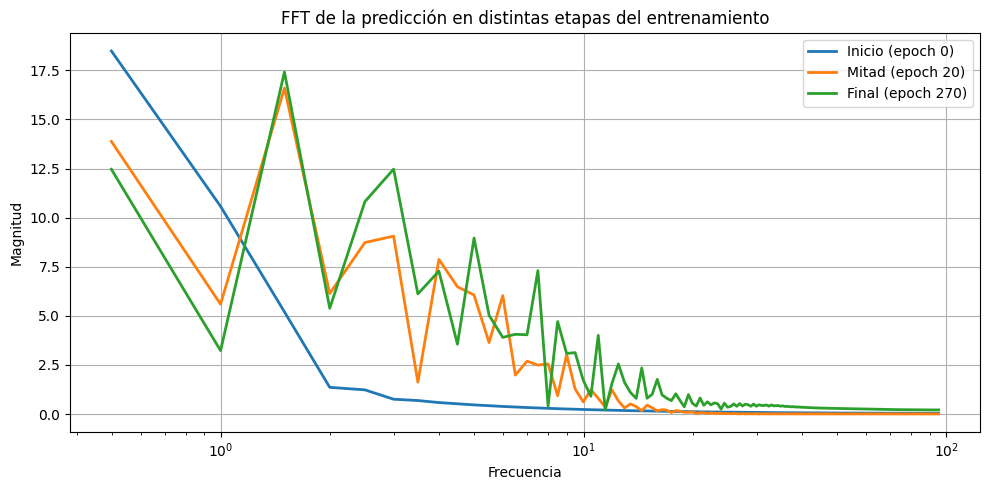

In [328]:
x_coords = xx_filt[:, 0]  # para calcular spacing
plot_ffts_during_training(results["log_params"], xx_filt, x_coords, batched_predict)


In [289]:
x_vals[1]

Array(-0.99477804, dtype=float32)

In [290]:
x_vals[0]

Array(-1., dtype=float32)

In [288]:
x_vals[1] - x_vals[0]

Array(0.00522196, dtype=float32)

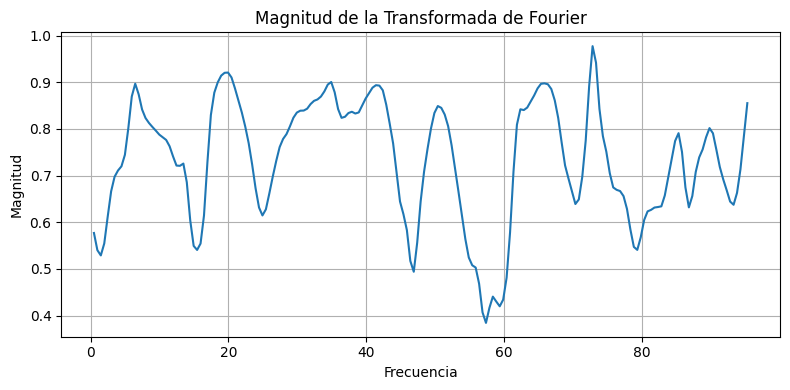

In [331]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# Aplanar y ordenar por x (por si no están ordenados)

# Calcular la FFT
fft_vals = jnp.fft.fft(ff_filt)
freqs = jnp.fft.fftfreq(len(ff_filt), d=(x_vals[1] - x_vals[0]))

# Magnitud de la FFT
fft_magnitude = jnp.abs(fft_vals)

# Graficar (sólo frecuencias positivas)
mask = freqs > 0
plt.figure(figsize=(8, 4))
plt.plot(freqs[mask], fft_magnitude[mask])
plt.title("Magnitud de la Transformada de Fourier")
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")
plt.grid(True)
#plt.xscale("log")
plt.tight_layout()
plt.show()

In [334]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

def compute_spectrum_evolution(log_params, xx_filt, x_coords, model_fn):
    spectra = []
    freqs = jnp.fft.fftfreq(len(x_coords), d=(x_coords[1] - x_coords[0]))

    mask = freqs > 0
    freqs = freqs[mask]

    for params in log_params:
        pred = model_fn(params, xx_filt).flatten()
        fft_vals = jnp.fft.fft(pred)
        fft_magnitude = jnp.abs(fft_vals)[mask]
        spectra.append(fft_magnitude)

    spectra = jnp.stack(spectra)  # shape: (epochs, freqs)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(spectra.T, aspect="auto", origin="lower",
               extent=[0, len(log_params)*10, freqs[0], freqs[-1]],
               cmap="viridis")
    plt.colorbar(label="Magnitud FFT")
    plt.xlabel("Epoch")
    plt.ylabel("Frecuencia")
    plt.yscale("log")
    plt.title("Evolución espectral durante el entrenamiento")
    plt.tight_layout()
    plt.show()


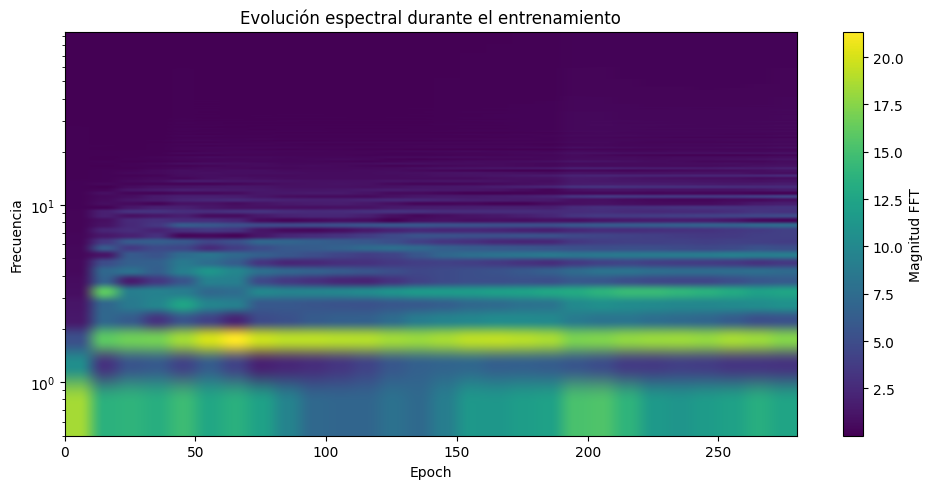

In [335]:
compute_spectrum_evolution(
    log_params=results["log_params"],
    xx_filt=xx_filt,
    x_coords=xx_filt[:, 0],
    model_fn=batched_predict
)
